In [ ]:
# Analyse von Zeitkategorien für Untersuchungsgebiet Berlin
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

In [ ]:
# Generelle zeitlich differenzierte Analyse von Histogrammdaten für ganz Berlin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import gc
import os
import random
import json
from tqdm.auto import tqdm
import pyarrow.parquet as pq
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

# =========================================================
# CONFIGURATION
# =========================================================

# File paths
PARQUET_FILE = "data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet"
OUTPUT_DIR = "analysis_results/000_Zeitliche_Analysen

# Analysis parameters
SPEED_BINS = np.arange(32)    # Speed bins (0 to 31+ km/h)

# Column naming patterns
SPEED_COL_PATTERN = "{}_speed"    # Pattern for speed column (format with period)
HIST_COL_PATTERN = "{}_speeds"    # Pattern for histogram column (format with period)
LENGTH_COL = "length_m"           # Column for segment length in meters

# =========================================================
# 1. DATA LOADING
# =========================================================

def scan_parquet_schema(file_path):
    """
    Scan the parquet file schema to get column names
    """
    print(f"Scanning parquet schema from {file_path}...")
    
    # Open the parquet file and read metadata only
    parquet_file = pq.ParquetFile(file_path)
    schema = parquet_file.schema
    
    # Extract column names from schema
    column_names = schema.names
    
    print(f"Found {len(column_names)} columns in schema")
    return column_names

def load_period_data(file_path, period):
    """
    Load data needed for one period
    
    Parameters:
    - file_path: Path to parquet file
    - period: The time period to analyze
    
    Returns:
    - DataFrame with just the needed columns for this period
    """
    # Define column names for this period
    speed_col = SPEED_COL_PATTERN.format(period)
    hist_col = HIST_COL_PATTERN.format(period)
    
    # Required columns
    columns = [LENGTH_COL, speed_col, hist_col]
    
    print(f"Loading data for period {period}...")
    
    try:
        # Load with pandas
        df = pd.read_parquet(
            file_path, 
            columns=columns
        )
        
        print(f"Loaded {len(df)} rows with {len(df.columns)} columns")
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        import traceback
        traceback.print_exc()
        return None

def parse_histogram(hist_str):
    """
    Parse histogram string to numpy array
    """
    try:
        if isinstance(hist_str, str):
            hist_str = hist_str.strip('[]')
            # Fast NumPy parsing
            try:
                values = np.fromstring(hist_str, sep=',')
                return values
            except:
                # Fallback to manual parsing if NumPy method fails
                values = [float(x) for x in hist_str.split(',')]
                return np.array(values)
        else:
            return np.zeros(len(SPEED_BINS))  # Return zeros for missing histograms
    except Exception as e:
        print(f"Error parsing histogram: {e}")
        return np.zeros(len(SPEED_BINS))

def calculate_all_weighted_statistics(histogram):
    """
    Calculate all statistics from a histogram in a single efficient pass.
    Returns a dictionary with all statistics.
    
    This approach is borrowed from Code 2 (OSM Type Analysis).
    """
    if np.sum(histogram) == 0:
        return {
            'mean': np.nan,
            'median': np.nan,
            'std': np.nan,
            'percentile_5': np.nan,
            'percentile_25': np.nan,
            'percentile_75': np.nan,
            'percentile_95': np.nan,
            'min': np.nan,
            'max': np.nan,
            'cv': np.nan,
            'skewness': np.nan,
            'kurtosis': np.nan,
            'entropy': np.nan,
            'p_0_5': np.nan,
            'p_5_15': np.nan,
            'p_15_25': np.nan,
            'p_25_plus': np.nan
        }
    
    speed_bins = np.arange(32)  # 0-31 km/h
    total_count = np.sum(histogram)
    
    # Normalize the histogram
    norm_hist = histogram / total_count
    
    # Calculate weighted mean in one step
    mean = np.sum(speed_bins * norm_hist)
    
    # Calculate variance and std in one step
    variance = np.sum(((speed_bins - mean) ** 2) * norm_hist)
    std = np.sqrt(variance)
    
    # Calculate cumulative distribution once
    cum_dist = np.cumsum(norm_hist)
    
    # Find min/max with data present
    nonzero_indices = np.nonzero(histogram)[0]
    if len(nonzero_indices) > 0:
        min_idx = nonzero_indices[0]
        max_idx = nonzero_indices[-1]
    else:
        min_idx = 0
        max_idx = 0
    
    # Calculate percentiles efficiently
    percentile_5 = np.interp(0.05, cum_dist, speed_bins)
    percentile_25 = np.interp(0.25, cum_dist, speed_bins)
    median = np.interp(0.5, cum_dist, speed_bins)
    percentile_75 = np.interp(0.75, cum_dist, speed_bins)
    percentile_95 = np.interp(0.95, cum_dist, speed_bins)
    
    # Calculate coefficient of variation
    cv = std / mean if mean > 0 else np.nan
    
    # Calculate skewness
    if std > 0:
        skewness = np.sum(norm_hist * ((speed_bins - mean) / std)**3)
    else:
        skewness = np.nan
    
    # Calculate kurtosis
    if std > 0:
        kurtosis = np.sum(norm_hist * ((speed_bins - mean) / std)**4) - 3
    else:
        kurtosis = np.nan
    
    # Calculate entropy
    non_zero_dist = norm_hist[norm_hist > 0]
    entropy = -np.sum(non_zero_dist * np.log(non_zero_dist)) if len(non_zero_dist) > 0 else 0
    
    # Calculate percentage in each speed range
    p_0_5 = np.sum(norm_hist[0:6])      # 0-5 km/h
    p_5_15 = np.sum(norm_hist[5:16])    # 5-15 km/h
    p_15_25 = np.sum(norm_hist[15:26])  # 15-25 km/h
    p_25_plus = np.sum(norm_hist[25:])  # 25+ km/h
    
    return {
        'mean': mean,
        'median': median,
        'std': std,
        'percentile_5': percentile_5,
        'percentile_25': percentile_25,
        'percentile_75': percentile_75,
        'percentile_95': percentile_95,
        'min': speed_bins[min_idx],
        'max': speed_bins[max_idx],
        'cv': cv,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy,
        'p_0_5': p_0_5,
        'p_5_15': p_5_15,
        'p_15_25': p_15_25,
        'p_25_plus': p_25_plus
    }

def analyze_period(file_path, period):
    """
    Analyze a single time period using efficient histogram calculations
    (no confidence intervals)
    """
    # Load the data for this period
    data = load_period_data(file_path, period)
    
    if data is None or len(data) == 0:
        print(f"No data available for period {period}")
        return None
    
    # Get column names for this period
    speed_col = SPEED_COL_PATTERN.format(period)
    hist_col = HIST_COL_PATTERN.format(period)
    
    # Filter out rows with missing data
    valid_data = data.dropna(subset=[speed_col, LENGTH_COL])
    print(f"Analyzing {len(valid_data)} valid rows for period {period}")
    
    if len(valid_data) == 0:
        print(f"No valid data for period {period} after filtering")
        return None
    
    # Process histograms and length weighting
    # Now we'll directly aggregate histograms with length weighting, like in Code 2
    length_weighted_agg_hist = np.zeros(32)
    total_length = 0
    segment_count = 0
    segment_lengths = []
    
    print("Processing histograms...")
    for _, row in tqdm(valid_data.iterrows(), total=len(valid_data), disable=len(valid_data) > 10000):
        hist = parse_histogram(row[hist_col])
        segment_length = row[LENGTH_COL]
        
        if len(hist) > 0 and np.sum(hist) > 0:  # Only include non-empty histograms
            # Add to the aggregated histogram with length weighting
            length_weighted_agg_hist += hist * segment_length
            total_length += segment_length
            segment_count += 1
            segment_lengths.append(segment_length)
    
    if segment_count == 0:
        print(f"No valid histograms for period {period}")
        return None
    
    print(f"Analyzed {segment_count} valid histograms with total length of {total_length/1000:.2f} km")
    
    # Calculate effective sample size (from Code 2)
    effective_n = 0
    if segment_lengths:
        sum_weights = np.sum(segment_lengths)
        sum_weights_squared = np.sum(np.square(segment_lengths))
        if sum_weights_squared > 0:
            effective_n = sum_weights**2 / sum_weights_squared
    
    # Store the raw weighted histogram data
    raw_hist_data = length_weighted_agg_hist.copy()
    
    # Calculate all statistics from the aggregated histogram
    stats = calculate_all_weighted_statistics(length_weighted_agg_hist)
    
    # Normalize to get distribution
    total = np.sum(length_weighted_agg_hist)
    if total > 0:
        citywide_dist = length_weighted_agg_hist / total
    else:
        citywide_dist = np.zeros_like(length_weighted_agg_hist)
    
    # Create results dictionary
    stats_dict = {
        'period': period,
        'total_samples': segment_count,
        'total_length_km': total_length / 1000,
        'effective_n': effective_n,
        'raw_hist': raw_hist_data.tolist(),  # Store raw histogram data
        'distribution': citywide_dist.tolist()  # Store normalized distribution
    }
    
    # Add all statistics to the dictionary
    stats_dict.update(stats)
    
    # Clean up memory
    del data, valid_data, segment_lengths
    gc.collect()
    
    return stats_dict

# =========================================================
# 2. PROCESSING & VISUALIZATION
# =========================================================

def create_interactive_category_comparison_plot(results):
    """
    Create interactive histogram plot showing summed histograms for different categories 
    (combining 2023 and 2024 data for each category)
    
    Parameters:
    - results: List of results dictionaries
    
    Returns:
    - Plotly figure object
    """
    import plotly.graph_objects as go
    import numpy as np
    import os
    
    print("Creating interactive histogram with summed data for all categories")
    
    # Categories to analyze
    categories = ['weekday', 'weekend', 'rush_am', 'rush_pm', 'rush_combined', 
                 'weekday_day', 'weekday_night', 'weekend_day', 'weekend_night']
    
    # Dictionary to store aggregated histograms for each category
    category_data = {}
    category_means = {}
    category_counts = {}
    
    # Process all results to extract and sum histogram data by category
    for category in categories:
        category_data[category] = None
        category_counts[category] = 0
        
        for result in results:
            period = result['period']
            
            # Check if this is one of our categories
            if f"all_{category}" in period:
                # Extract the raw histogram data
                hist_data = np.array(result['raw_hist'])
                
                # Add to our accumulated data for this category
                if category_data[category] is None:
                    category_data[category] = hist_data
                else:
                    category_data[category] += hist_data
                
                # Increment count
                category_counts[category] += 1
    
    # Normalize histograms and calculate means
    for category in categories:
        if category_data[category] is not None and np.sum(category_data[category]) > 0:
            category_data[category] = category_data[category] / np.sum(category_data[category])
            category_means[category] = np.sum(np.arange(32) * category_data[category])
        else:
            # Remove categories with no data
            category_data.pop(category)
            category_counts.pop(category)
            print(f"No data found for category: {category}")
    
    # Create figure
    fig = go.Figure()
    
    # Color palette for better distinction between lines
    colors = [
        'rgba(31, 119, 180, 0.8)',   # blue
        'rgba(255, 127, 14, 0.8)',   # orange
        'rgba(44, 160, 44, 0.8)',    # green
        'rgba(214, 39, 40, 0.8)',    # red
        'rgba(148, 103, 189, 0.8)',  # purple
        'rgba(140, 86, 75, 0.8)',    # brown
        'rgba(227, 119, 194, 0.8)',  # pink
        'rgba(127, 127, 127, 0.8)',  # gray
        'rgba(188, 189, 34, 0.8)',   # lime
    ]
    
    # Add traces for each category
    for i, (category, hist_values) in enumerate(category_data.items()):
        color_idx = i % len(colors)
        
        # Format category name for display
        display_name = category.replace('_', ' ').title()
        mean_value = category_means[category]
        count = category_counts[category]
        
        fig.add_trace(go.Scatter(
            x=list(range(32)),  # Speed bins
            y=hist_values,
            mode='lines',
            name=f"{display_name} (n={count}, μ={mean_value:.1f})",
            hoverinfo='x+y+name',
            line=dict(width=3, color=colors[color_idx]),
            marker=dict(size=8)
        ))
        
        # Add vertical line for the mean
        fig.add_shape(
            type="line",
            x0=mean_value,
            y0=0,
            x1=mean_value,
            y1=max([max(data) for data in category_data.values()]) * 0.7,
            line=dict(color=colors[color_idx], width=2, dash="dash"),
            name=f"Mean {display_name}"
        )
    
    # Update layout
    fig.update_layout(
        title='Speed Distribution by Category (Summed 2023-2024 Data)',
        xaxis_title='Speed (km/h)',
        yaxis_title='Normalized Frequency',
        hovermode='closest',
        legend=dict(
            x=1.02,
            y=1,
            xanchor='left',
            yanchor='top'
        ),
        width=1000,
        height=600,
        template='plotly_white'
    )
    
    # Add buttons to show specific category groups
    button_list = []
    
    # All categories
    button_list.append(dict(
        label="All Categories",
        method="update",
        args=[{"visible": [True] * len(category_data)}]
    ))
    
    # Only weekday/weekend
    weekday_weekend_visible = [True if 'weekday' in cat or 'weekend' in cat and 'day' not in cat and 'night' not in cat else False 
                              for cat in category_data.keys()]
    button_list.append(dict(
        label="Weekday vs Weekend",
        method="update",
        args=[{"visible": weekday_weekend_visible}]
    ))
    
    # Only rush hour periods
    rush_visible = [True if 'rush' in cat else False for cat in category_data.keys()]
    button_list.append(dict(
        label="Rush Hours",
        method="update",
        args=[{"visible": rush_visible}]
    ))
    
    # Day vs Night
    day_night_visible = [True if 'day' in cat or 'night' in cat else False for cat in category_data.keys()]
    button_list.append(dict(
        label="Day vs Night",
        method="update",
        args=[{"visible": day_night_visible}]
    ))
    
    # Add the buttons to the layout
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                active=0,
                x=0.5,
                y=1.15,
                buttons=button_list
            )
        ]
    )
    
    # Add hover info that highlights the active trace
    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Arial"
        )
    )
    
    # Save as HTML
    output_dir = OUTPUT_DIR
    os.makedirs(output_dir, exist_ok=True)
    html_file = os.path.join(output_dir, "interactive_category_histogram.html")
    fig.write_html(html_file, include_plotlyjs='cdn')
    print(f"Saved interactive histogram to {html_file}")
    
    return fig

def plot_time_category_comparison_by_year(results, output_folder):
    """
    Compare time categories across different years
    Modified to not use confidence intervals
    """
    if not results:
        print("No results to plot")
        return
    
    # Filter out monthly data, we want categories like weekday, weekend, etc.
    category_data = [r for r in results if r['period_type'] != 'monthly' 
                    and r['year'] != 'NA']
    
    if not category_data:
        print("No time category data to plot")
        return
    
    # Create dataframe for easier plotting
    df = pd.DataFrame(category_data)
    
    # Define important categories to compare
    key_categories = ['weekday', 'weekend', 'rush_am', 'rush_pm', 'rush_combined',
                      'weekday_day', 'weekday_night', 'weekend_day', 'weekend_night']
    df = df[df['period_type'].isin(key_categories)]
    
    if len(df) == 0:
        print("No key time category data found")
        return
    
    # Define colors for different years
    colors = {'2023': 'blue', '2024': 'red'}
    
    # 1. Bar chart comparing mean speeds by category and year
    plt.figure(figsize=(14, 8))
    
    # Set up bars
    categories = df['period_type'].unique()
    x = np.arange(len(categories))
    width = 0.35
    
    # Plot bars for each year
    for i, year in enumerate(sorted(df['year'].unique())):
        year_data = df[df['year'] == year]
        means = []
        stds = []
        
        for cat in categories:
            cat_data = year_data[year_data['period_type'] == cat]
            means.append(cat_data['mean'].values[0] if len(cat_data) > 0 else 0)
            stds.append(cat_data['std'].values[0] if len(cat_data) > 0 else 0)
        
        offset = -width/2 if i == 0 else width/2
        bars = plt.bar(x + offset, means, width, label=year, 
               color=colors.get(year, f'C{i}'), alpha=0.7)
        
        # Add error bars for standard deviations
        plt.errorbar(x + offset, means, yerr=stds,
                   fmt='none', color='black', capsize=3)
    
    plt.xlabel('Time Category')
    plt.ylabel('Mean Speed (km/h)')
    plt.title('Comparison of Mean Speeds by Time Category and Year')
    plt.xticks(x, categories, rotation=45)
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'category_year_comparison.png'))
    plt.close()
    
    # 2. Radar chart for multidimensional comparison
    metrics = ['mean', 'std', 'p_0_5', 'p_5_15', 'p_15_25', 'p_25_plus']
    metric_labels = ['Mean Speed', 'Std Dev', '0-5 km/h', '5-15 km/h', '15-25 km/h', '25+ km/h']
    
    # For each category, compare years
    for category in categories:
        cat_data = df[df['period_type'] == category]
        
        # Skip if we don't have data for multiple years
        if len(cat_data['year'].unique()) < 2:
            continue
        
        # Create the radar chart
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Close the circle
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        
        for year in sorted(cat_data['year'].unique()):
            year_row = cat_data[cat_data['year'] == year].iloc[0]
            
            # Get values and scale to 0-1 range for better visualization
            values = []
            for metric in metrics:
                val = year_row[metric]
                if val == "NaN" or np.isnan(val):
                    val = 0
                values.append(float(val))
            
            # If std and mean are involved, they need different scaling
            values[0] = values[0] / 25  # Scale mean by assuming max is ~25 km/h
            values[1] = values[1] / 10  # Scale std by assuming max is ~10
            
            # Close the loop
            values += values[:1]
            
            # Plot
            ax.plot(angles, values, 'o-', linewidth=2, 
                   label=year, color=colors.get(year, 'gray'))
            ax.fill(angles, values, alpha=0.1, color=colors.get(year, 'gray'))
        
        # Set labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_labels)
        
        # Add legend and title
        ax.legend(loc='upper right')
        ax.set_title(f'Metrics Comparison for {category.capitalize()} by Year')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'radar_{category}_year_comparison.png'))
        plt.close()
        
    # 3. Plot summed histogram comparison for all time categories
    plt.figure(figsize=(14, 8))
    
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        for cat in categories:
            cat_data = year_data[year_data['period_type'] == cat]
            if len(cat_data) > 0:
                row = cat_data.iloc[0]
                plt.plot(np.arange(32), row['distribution'], 
                        label=f"{cat} ({year})",
                        alpha=0.7, marker='o', markersize=4)
    
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Proportion')
    plt.title('Speed Distributions by Time Category and Year')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'all_category_distributions.png'))
    plt.close()

def save_results(results, output_folder, filename='cycling_analysis_results.csv'):
    """
    Save results to CSV file
    """
    if not results:
        print("No results to save")
        return
    
    # Convert NumPy types to Python native types
    def convert_numpy_types(obj):
        if isinstance(obj, dict):
            return {k: convert_numpy_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return convert_numpy_types(obj.tolist())
        else:
            return obj
    
    # Convert all NumPy types to Python native types
    json_safe_results = convert_numpy_types(results)
    
    # Create a copy of results without the distributions (they're too large for CSV)
    csv_results = []
    for result in json_safe_results:
        result_copy = result.copy()
        if 'distribution' in result_copy:
            del result_copy['distribution']
        if 'raw_hist' in result_copy:
            del result_copy['raw_hist']
        csv_results.append(result_copy)
    
    # Convert to DataFrame and save
    df = pd.DataFrame(csv_results)
    csv_path = os.path.join(output_folder, filename)
    df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
    
    # Also save as JSON for full data including distributions
    try:
        json_path = os.path.join(output_folder, 'cycling_analysis_results.json')
        with open(json_path, 'w') as f:
            json.dump(json_safe_results, f)
        print(f"Full results including distributions saved to {json_path}")
    except Exception as e:
        print(f"Error saving JSON: {e}")
        # Fallback: save without distributions
        json_basic_path = os.path.join(output_folder, 'cycling_analysis_basic_results.json')
        with open(json_basic_path, 'w') as f:
            json.dump(csv_results, f)
        print(f"Basic results (without distributions) saved to {json_basic_path}")
        
    # Save raw histogram data to a separate CSV
    try:
        hist_data = []
        for result in results:
            if 'raw_hist' in result:
                hist_data.append({
                    'period': result['period'],
                    'raw_histogram': result['raw_hist']
                })
        
        if hist_data:
            hist_path = os.path.join(output_folder, 'raw_histograms.json')
            with open(hist_path, 'w') as f:
                json.dump(hist_data, f)
            print(f"Raw histogram data saved to {hist_path}")
    except Exception as e:
        print(f"Error saving raw histogram data: {e}")

def print_summary(results):
    """
    Print a summary of the results
    Updated to not reference confidence intervals
    """
    if not results:
        print("No results to summarize")
        return
    
    print("\n=== ANALYSIS SUMMARY ===")
    
    # Group by year and period type
    year_period_groups = {}
    for result in results:
        year = result['year']
        period_type = result['period_type']
        key = f"{year}_{period_type}"
        
        if key not in year_period_groups:
            year_period_groups[key] = []
        
        year_period_groups[key].append(result)
    
    # Print summary for each group
    for key, group_results in year_period_groups.items():
        if len(group_results) == 0:
            continue
        
        parts = key.split('_', 1)  # Split only at the first underscore
        if len(parts) != 2:
            print(f"Warning: Unexpected key format: {key}")
            continue
            
        year, period_type = parts
        if year == 'NA':
            continue  # Skip unknown years
            
        print(f"\n{year} - {period_type.upper()} PERIODS ({len(group_results)})")
        
        # Calculate average metrics using Python types
        def safe_mean(values):
            valid_values = [v for v in values if not (isinstance(v, str)) and not np.isnan(v)]
            return sum(valid_values) / len(valid_values) if valid_values else 0
        
        avg_mean = safe_mean([r['mean'] for r in group_results])
        avg_std = safe_mean([r['std'] for r in group_results])
        avg_p_0_5 = safe_mean([r['p_0_5'] for r in group_results])
        avg_p_5_15 = safe_mean([r['p_5_15'] for r in group_results])
        avg_p_15_25 = safe_mean([r['p_15_25'] for r in group_results])
        avg_p_25_plus = safe_mean([r['p_25_plus'] for r in group_results])
        
        # Print summary statistics
        print(f"  Average Speed: {avg_mean:.2f} km/h (±{avg_std:.2f})")
        print(f"  Speed Ranges: {avg_p_0_5*100:.1f}% (0-5 km/h), "
              f"{avg_p_5_15*100:.1f}% (5-15 km/h), "
              f"{avg_p_15_25*100:.1f}% (15-25 km/h), "
              f"{avg_p_25_plus*100:.1f}% (25+ km/h)")
    
    # Compare year-to-year for year-wide data
    yearly_data = {}
    for result in results:
        if result['period_type'] in ['yearly', 'warm_season', 'cold_season', 
                                   'weekday', 'weekend', 'rush_am', 'rush_pm', 'rush_combined',
                                   'weekday_day', 'weekday_night', 'weekend_day', 'weekend_night']:
            year = result['year']
            if year not in yearly_data:
                yearly_data[year] = {}
            
            yearly_data[year][result['period_type']] = result
    
    # Also compare 2023 vs 2024 for same time categories
    print("\n=== TIME CATEGORY YEAR-OVER-YEAR COMPARISONS ===")
    
    time_categories = ['weekday', 'weekend', 'rush_am', 'rush_pm', 'rush_combined',
                     'weekday_day', 'weekday_night', 'weekend_day', 'weekend_night']
    
    for category in time_categories:
        if '2023' in yearly_data and '2024' in yearly_data:
            if category in yearly_data['2023'] and category in yearly_data['2024']:
                data_2023 = yearly_data['2023'][category]
                data_2024 = yearly_data['2024'][category]
                
                print(f"\n{category.capitalize()} Comparison:")
                print(f"  2023 Speed: {data_2023['mean']:.2f} km/h")
                print(f"  2024 Speed: {data_2024['mean']:.2f} km/h")
                
                # Calculate percent change
                pct_change = (data_2024['mean'] - data_2023['mean']) / data_2023['mean'] * 100
                print(f"  Change: {pct_change:.2f}%")
                
                # Compare speed distributions
                print(f"  Speed Category Changes (2023 → 2024):")
                for cat, label in zip(['p_0_5', 'p_5_15', 'p_15_25', 'p_25_plus'], 
                                     ['0-5 km/h', '5-15 km/h', '15-25 km/h', '25+ km/h']):
                    pct_2023 = data_2023[cat] * 100
                    pct_2024 = data_2024[cat] * 100
                    diff = pct_2024 - pct_2023
                    print(f"    {label}: {pct_2023:.1f}% → {pct_2024:.1f}% ({diff:+.1f}%)")
    
    # Also compare 2023 vs 2024 for same months if available
    print("\n=== MONTHLY YEAR-OVER-YEAR COMPARISONS ===")
    
    # Filter to only include monthly data
    monthly_data = [r for r in results if r['period_type'] == 'monthly']
    
    # Group by month
    month_groups = {}
    for result in monthly_data:
        month = result['month']
        if month not in month_groups:
            month_groups[month] = {}
        
        month_groups[month][result['year']] = result
    
    # Print comparison for each month that has data for both years
    for month, year_data in month_groups.items():
        if '2023' in year_data and '2024' in year_data:
            data_2023 = year_data['2023']
            data_2024 = year_data['2024']
            
            print(f"\nMonth {month} Comparison:")
            print(f"  2023 Speed: {data_2023['mean']:.2f} km/h")
            print(f"  2024 Speed: {data_2024['mean']:.2f} km/h")
            
            # Calculate percent change
            pct_change = (data_2024['mean'] - data_2023['mean']) / data_2023['mean'] * 100
            print(f"  Change: {pct_change:.2f}%")
            
            # Compare speed distributions
            print(f"  Speed Category Changes (2023 → 2024):")
            for cat, label in zip(['p_0_5', 'p_5_15', 'p_15_25', 'p_25_plus'], 
                                 ['0-5 km/h', '5-15 km/h', '15-25 km/h', '25+ km/h']):
                pct_2023 = data_2023[cat] * 100
                pct_2024 = data_2024[cat] * 100
                diff = pct_2024 - pct_2023
                print(f"    {label}: {pct_2023:.1f}% → {pct_2024:.1f}% ({diff:+.1f}%)")
    
    print("\n=== END OF SUMMARY ===")

def create_interactive_histogram_plot(results, output_dir=None, filename="interactive_histogram.html"):
    """
    Create interactive histogram plot with Plotly for time-based categories
    
    Parameters:
    - results: List of result dictionaries from the analysis
    - output_dir: Directory to save the HTML file (defaults to OUTPUT_DIR if None)
    - filename: Name of the HTML file to save
    
    Returns:
    - Plotly figure object
    """
    print("Creating enhanced interactive histogram plot")
    
    if output_dir is None:
        output_dir = OUTPUT_DIR
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Group results by period type for better organization
    period_types = {}
    for result in results:
        period_type = result['period_type']
        if period_type not in period_types:
            period_types[period_type] = []
        period_types[period_type].append(result)
    
    # Define interesting period types to include
    interesting_types = [
        'yearly', 'monthly', 'weekday', 'weekend', 'rush_am', 'rush_pm',
        'weekday_day', 'weekday_night', 'weekend_day', 'weekend_night',
        'warm_season', 'cold_season'
    ]
    
    # Collect data for each period from results
    all_periods = []
    all_histograms = []
    all_stats = []
    
    for period_type in interesting_types:
        if period_type in period_types:
            for result in period_types[period_type]:
                if 'distribution' in result and 'raw_hist' in result:
                    # Create period label with year
                    if result['year'] != 'NA':
                        period_label = f"{result['period']} ({result['year']})"
                    else:
                        period_label = result['period']
                    
                    all_periods.append(period_label)
                    all_histograms.append(result['distribution'])
                    
                    # Collect statistics for hover info
                    stat_info = {
                        'mean': result.get('mean', 0),
                        'median': result.get('median', 0),
                        'std': result.get('std', 0),
                        'total_samples': result.get('total_samples', 0),
                        'total_length_km': result.get('total_length_km', 0),
                        'effective_n': result.get('effective_n', 0)
                    }
                    all_stats.append(stat_info)
    
    # Create figure
    fig = go.Figure()
    
    # Color palette for better distinction between lines
    colors = [
        'rgba(31, 119, 180, 0.8)',   # blue
        'rgba(255, 127, 14, 0.8)',   # orange
        'rgba(44, 160, 44, 0.8)',    # green
        'rgba(214, 39, 40, 0.8)',    # red
        'rgba(148, 103, 189, 0.8)',  # purple
        'rgba(140, 86, 75, 0.8)',    # brown
        'rgba(227, 119, 194, 0.8)',  # pink
        'rgba(127, 127, 127, 0.8)',  # gray
        'rgba(188, 189, 34, 0.8)',   # lime
        'rgba(23, 190, 207, 0.8)',   # cyan
    ]
    
    # Add traces for each period
    for i, (period, hist_values, stats) in enumerate(zip(all_periods, all_histograms, all_stats)):
        color_idx = i % len(colors)
        
        # Format values for display
        mean_value = stats['mean']
        median_value = stats['median']
        std_value = stats['std']
        total_samples = stats['total_samples']
        
        if 'total_length_km' in stats and stats['total_length_km'] > 0:
            total_length_km = stats['total_length_km']
            length_str = f"{total_length_km:.1f} km"
        else:
            length_str = "N/A"
            
        if 'effective_n' in stats and stats['effective_n'] > 0:
            effective_n = stats['effective_n']
            effective_n_str = f", eff_n={effective_n:.1f}"
        else:
            effective_n_str = ""
        
        # Add trace with enhanced hover information
        fig.add_trace(go.Scatter(
            x=list(range(32)),  # Speed bins
            y=hist_values,
            mode='lines',
            name=f"{period}",
            hoverinfo='x+y+name',
            hovertemplate='<b>%{fullData.name}</b><br>' +
                         'Speed: %{x} km/h<br>' +
                         'Frequency: %{y:.4f}<br>' +
                         f'Mean: {mean_value:.1f} km/h<br>' +
                         f'Median: {median_value:.1f} km/h<br>' +
                         f'Std Dev: {std_value:.2f}<br>' +
                         f'Length: {length_str}<br>' +
                         f'Samples: {total_samples:,}{effective_n_str}',
            line=dict(width=3, color=colors[color_idx]),
            marker=dict(size=8)
        ))
        
        # Add vertical line for the mean
        fig.add_shape(
            type="line",
            x0=mean_value,
            y0=0,
            x1=mean_value,
            y1=max([max(hist) if max(hist) > 0 else 0.1 for hist in all_histograms]) * 0.7,
            line=dict(color=colors[color_idx], width=2, dash="dash"),
            name=f"Mean {period}"
        )
    
    # Update layout
    fig.update_layout(
        title='Speed Distribution Comparison Across Time Periods',
        xaxis_title='Speed (km/h)',
        yaxis_title='Normalized Frequency',
        hovermode='closest',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.02
        ),
        width=1000,
        height=600,
        template='plotly_white'
    )
    
    # Create category buttons to filter different types of periods
    button_list = []
    
    # All periods button
    button_list.append(dict(
        label="All Periods",
        method="update",
        args=[{"visible": [True] * len(all_periods)}]
    ))
    
    # Group periods by type
    period_type_indices = {}
    for i, period in enumerate(all_periods):
        for type_name in interesting_types:
            if type_name in period.lower():
                if type_name not in period_type_indices:
                    period_type_indices[type_name] = []
                period_type_indices[type_name].append(i)
    
    # Add buttons for each period type
    for type_name in period_type_indices:
        # Create visibility list
        visibility = [False] * len(all_periods)
        for idx in period_type_indices[type_name]:
            visibility[idx] = True
        
        # Format button label
        label = type_name.replace('_', ' ').title()
        
        button_list.append(dict(
            label=label,
            method="update",
            args=[{"visible": visibility}]
        ))
    
    # Add year-specific buttons (2023, 2024)
    for year in ['2023', '2024']:
        visibility = [True if year in period else False for period in all_periods]
        button_list.append(dict(
            label=f"Only {year}",
            method="update",
            args=[{"visible": visibility}]
        ))
    
    # Add the buttons to the layout
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                active=0,
                x=0.5,
                y=1.15,
                buttons=button_list
            )
        ]
    )
    
    # Add hover info that highlights the active trace
    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        )
    )
    
    # Animation settings to help compare distribution shapes
    fig.update_layout(
        sliders=[dict(
            active=0,
            steps=[dict(
                method="update",
                args=[{"visible": [i == j for j in range(len(all_periods))]},
                     {"title": f"Speed Distribution: {all_periods[i]}"}],
                label=str(i+1)
            ) for i in range(len(all_periods))],
            transition={"duration": 300},
            x=0.5,
            y=0,
            currentvalue={"prefix": "Period: "},
            len=0.9
        )]
    )
    
    # Save as HTML
    html_file = os.path.join(output_dir, filename)
    fig.write_html(html_file, include_plotlyjs='cdn')
    print(f"Saved enhanced interactive histogram to {html_file}")
    
    return fig

def categorize_periods(results_list):
    """
    Categorize periods by type (monthly, weekday, etc.)
    """
    if not results_list:
        return None
    
    # Create a new list with categorization
    categorized_results = []
    
    for result in results_list:
        period = result['period']
        result_copy = result.copy()
        
        # Initialize categorization fields
        result_copy['period_type'] = 'other'
        result_copy['year'] = 'NA'
        result_copy['month'] = 'NA'
        result_copy['season'] = 'NA'
        
        # Monthly periods (e.g., 23-04 or 24-01)
        if '-' in period and len(period) == 5 and period[2] == '-':
            result_copy['period_type'] = 'monthly'
            year_part, month_part = period.split('-')
            
            result_copy['year'] = '20' + year_part
            result_copy['month'] = month_part
            
            # Determine season
            month_num = int(month_part)
            if month_num in [12, 1, 2]:
                result_copy['season'] = 'winter'
            elif month_num in [3, 4, 5]:
                result_copy['season'] = 'spring'
            elif month_num in [6, 7, 8]:
                result_copy['season'] = 'summer'
            else:  # 9, 10, 11
                result_copy['season'] = 'fall'
                
        # Year-wide aggregates (e.g., 23-all, 24-all)
        elif period in ['23-all', '24-all', '2304-2412_all']:
            result_copy['period_type'] = 'yearly'
            if period.startswith('23'):
                result_copy['year'] = '2023'
            elif period.startswith('24'):
                result_copy['year'] = '2024'
            elif period.startswith('2304'):
                result_copy['year'] = '2023-2024'
                
        # Seasonal aggregates
        elif '_warm' in period or '_cold' in period:
            if '_warm' in period:
                result_copy['period_type'] = 'warm_season'
                result_copy['season'] = 'warm'
            else:
                result_copy['period_type'] = 'cold_season'
                result_copy['season'] = 'cold'
                
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
                
        # Time categories
        elif 'rush_am' in period:
            result_copy['period_type'] = 'rush_am'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'rush_pm' in period:
            result_copy['period_type'] = 'rush_pm'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'rush_combined' in period:
            result_copy['period_type'] = 'rush_combined'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'weekday_day' in period:
            result_copy['period_type'] = 'weekday_day'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'weekday_night' in period:
            result_copy['period_type'] = 'weekday_night'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'weekday' in period:
            result_copy['period_type'] = 'weekday'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'weekend_day' in period:
            result_copy['period_type'] = 'weekend_day'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'weekend_night' in period:
            result_copy['period_type'] = 'weekend_night'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
        elif 'weekend' in period:
            result_copy['period_type'] = 'weekend'
            if period.startswith('23-'):
                result_copy['year'] = '2023'
            elif period.startswith('24-'):
                result_copy['year'] = '2024'
            
        categorized_results.append(result_copy)
    
    return categorized_results

def plot_basic_results(results, output_folder):
    """
    Create basic plots from the results
    Modified to not use confidence intervals
    """
    if not results:
        print("No results to plot")
        return
    
    # Convert lists back to arrays for distributions
    for result in results:
        if 'distribution' in result:
            result['distribution'] = np.array(result['distribution'])
        if 'raw_hist' in result:
            result['raw_hist'] = np.array(result['raw_hist'])
    
    # Group results by period type
    period_types = {}
    for result in results:
        period_type = result['period_type']
        if period_type not in period_types:
            period_types[period_type] = []
        period_types[period_type].append(result)
    
    # Plot monthly data if available
    if 'monthly' in period_types:
        monthly_data = period_types['monthly']
        
        # Group by year
        years = {}
        for result in monthly_data:
            year = result['year']
            if year not in years:
                years[year] = []
            years[year].append(result)
        
        # Plot each year separately
        for year, year_data in years.items():
            # Sort by month
            year_data.sort(key=lambda x: int(x['month']))
            
            # Extract data for plotting
            periods = [r['period'] for r in year_data]
            means = [r['mean'] for r in year_data]
            stds = [r['std'] for r in year_data]
            
            # Plot mean and std by month
            plt.figure(figsize=(10, 6))
            plt.errorbar(range(len(periods)), means, yerr=stds, fmt='o-', capsize=5, label='Mean ± Std')
            
            plt.xticks(range(len(periods)), periods, rotation=45)
            plt.ylabel('Speed (km/h)')
            plt.title(f'Mean Cycling Speed by Month ({year})')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'{year}_monthly_speeds.png'))
            plt.close()
            
            # Plot speed distributions for selected months
            plt.figure(figsize=(10, 6))
            
            # Select a few months to show (avoid overcrowding)
            if len(year_data) > 6:
                indices = np.linspace(0, len(year_data)-1, 6, dtype=int)
                plot_data = [year_data[i] for i in indices]
            else:
                plot_data = year_data
                
            for result in plot_data:
                plt.plot(np.arange(32), result['distribution'], label=result['period'], alpha=0.7)
                
            plt.xlabel('Speed (km/h)')
            plt.ylabel('Proportion')
            plt.title(f'Speed Distributions by Month ({year})')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'{year}_monthly_distributions.png'))
            plt.close()
            
            # Plot speed ranges
            p_0_5 = [r['p_0_5'] for r in year_data]
            p_5_15 = [r['p_5_15'] for r in year_data]
            p_15_25 = [r['p_15_25'] for r in year_data]
            p_25_plus = [r['p_25_plus'] for r in year_data]
            
            plt.figure(figsize=(10, 6))
            plt.stackplot(range(len(periods)), p_0_5, p_5_15, p_15_25, p_25_plus,
                         labels=['0-5 km/h', '5-15 km/h', '15-25 km/h', '25+ km/h'],
                         alpha=0.7)
            plt.xticks(range(len(periods)), periods, rotation=45)
            plt.ylabel('Proportion')
            plt.title(f'Speed Ranges by Month ({year})')
            plt.legend(loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'{year}_monthly_speed_ranges.png'))
            plt.close()
    
    # Compare time categories if available
    time_categories = [
        'weekday', 'weekend', 'rush_am', 'rush_pm', 'rush_combined',
        'weekday_day', 'weekday_night', 'weekend_day', 'weekend_night'
    ]
    
    # Group time category data by year
    year_categories = {}
    for cat in time_categories:
        if cat in period_types:
            # Group by year
            for result in period_types[cat]:
                year = result['year']
                if year not in year_categories:
                    year_categories[year] = {}
                
                if cat not in year_categories[year]:
                    year_categories[year][cat] = result
    
    # Plot time categories for each year
    for year, categories in year_categories.items():
        if not categories:
            continue
            
        # Plot mean speeds by category with standard deviations
        plt.figure(figsize=(12, 6))
        
        cat_names = list(categories.keys())
        means = [categories[cat]['mean'] for cat in cat_names]
        stds = [categories[cat]['std'] for cat in cat_names]
        
        # Create bar plot
        bars = plt.bar(cat_names, means)
        
        # Add standard deviation error bars
        plt.errorbar(range(len(cat_names)), means, yerr=stds,
                   fmt='none', color='black', capsize=5)
        
        plt.ylabel('Mean Speed (km/h)')
        plt.title(f'Mean Speed by Time Category ({year})')
        plt.grid(True, axis='y', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'{year}_category_means.png'))
        plt.close()
        
        # Plot distributions for different categories
        plt.figure(figsize=(12, 6))
        
        for cat, result in categories.items():
            plt.plot(np.arange(32), result['distribution'], label=cat, alpha=0.7)
            
        plt.xlabel('Speed (km/h)')
        plt.ylabel('Proportion')
        plt.title(f'Speed Distributions by Time Category ({year})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'{year}_category_distributions.png'))
        plt.close()
    
    # Plot comparison of all raw histograms
    plt.figure(figsize=(14, 10))
    
    # Group results by period type for better coloring
    period_types = set([r['period_type'] for r in results])
    type_colors = plt.cm.get_cmap('tab10', len(period_types))
    type_color_map = {pt: type_colors(i) for i, pt in enumerate(sorted(period_types))}
    
    # Plot each raw histogram as connected dots
    for i, result in enumerate(results):
        if 'raw_hist' in result:
            raw_hist = np.array(result['raw_hist'])
            # Normalize to better compare shapes
            if np.sum(raw_hist) > 0:
                norm_hist = raw_hist / np.sum(raw_hist)
                # Use period type for color grouping
                color = type_color_map[result['period_type']]
                plt.plot(np.arange(32), norm_hist, 'o-', 
                       label=result['period'], alpha=0.7, 
                       color=color)
    
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Normalized Count')
    plt.title('Comparison of All Speed Histograms')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Use a separate legend figure if many periods
    if len(results) > 10:
        # Create the legend on a separate figure
        legend_fig = plt.figure(figsize=(10, 10))
        legend_ax = legend_fig.add_subplot(111)
        
        # Add a dummy plot with labels
        for i, result in enumerate(results):
            if 'raw_hist' in result:
                legend_ax.plot([], [], 'o-', label=result['period'], 
                              color=type_color_map[result['period_type']])
        
        # Create the legend with small font
        legend = legend_ax.legend(loc='center', fontsize='small', ncol=3)
        legend_ax.axis('off')
        
        # Save the legend
        legend_fig.savefig(os.path.join(output_folder, 'histogram_legend.png'))
        plt.close(legend_fig)
        
        # Save the main plot without legend
        plt.savefig(os.path.join(output_folder, 'all_raw_histograms.png'))
    else:
        # Add legend to the main plot if not too many periods
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(os.path.join(output_folder, 'all_raw_histograms.png'))
    
    plt.show()
    plt.close()

def plot_monthly_comparison(results, output_folder):
    """
    Plot comparison of monthly data across years
    Modified to not use confidence intervals
    """
    if not results:
        print("No results to plot")
        return
    
    # Filter to only include monthly periods
    monthly_data = [r for r in results if r['period_type'] == 'monthly']
    
    if not monthly_data:
        print("No monthly data to plot")
        return
    
    # Create dataframe for easier plotting
    df = pd.DataFrame(monthly_data)
    
    # Convert month to numeric for proper sorting
    df['month_num'] = df['month'].astype(int)
    df = df.sort_values(['year', 'month_num'])
    
    # Create readable labels for x-axis
    df['month_year'] = df.apply(lambda x: f"{x['month']}/{x['year'][-2:]}", axis=1)
    
    # Define colors for different years
    colors = {'2023': 'blue', '2024': 'red'}
    
    # 1. Plot mean speeds by month with year grouping and standard deviations
    plt.figure(figsize=(14, 7))
    
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        
        # Plot means with error bars for standard deviation
        plt.errorbar(
            year_data['month_num'], 
            year_data['mean'],
            yerr=year_data['std'],
            fmt='o-', 
            linewidth=2, 
            label=f"{year} (mean ± std)", 
            color=colors.get(year, 'gray'),
            capsize=3
        )
    
    # Add month names on x-axis
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                  7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    plt.xticks(range(1, 13), [month_names[i] for i in range(1, 13)])
    
    plt.ylabel('Mean Speed (km/h)')
    plt.title('Monthly Mean Cycling Speed by Year (with Std Dev)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'yearly_monthly_comparison.png'))
    plt.close()
    
    # 2. Plot speed distributions for selected months
    plt.figure(figsize=(14, 7))
    
    # For each year, select a representative month (e.g., January)
    for year in df['year'].unique():
        # Try to get January data, or first available month
        year_data = df[(df['year'] == year) & (df['month_num'] == 1)]
        if len(year_data) == 0:
            # Get first available month for this year
            year_data = df[df['year'] == year].iloc[0:1]
        
        if len(year_data) > 0:
            row = year_data.iloc[0]
            month_label = month_names[row['month_num']]
            plt.plot(np.arange(32), row['distribution'], 
                    label=f"{month_label} {row['year']}", 
                    color=colors.get(row['year'], 'gray'),
                    linewidth=2, alpha=0.7)
    
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Proportion')
    plt.title('Speed Distributions by Year (Representative Month)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'yearly_distribution_comparison.png'))
    plt.close()
    
    # 3. Plot side-by-side comparison of key metrics
    metrics = ['mean', 'std', 'cv', 'skewness', 'entropy']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(14, 15), sharex=True)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        for year in df['year'].unique():
            year_data = df[df['year'] == year]
            # Convert string NaN to actual NaN
            if metric in ['cv', 'skewness', 'kurtosis', 'entropy']:
                year_data[metric] = year_data[metric].apply(
                    lambda x: np.nan if isinstance(x, str) and x == "NaN" else x)
            ax.plot(year_data['month_num'], year_data[metric], 
                   'o-', linewidth=2, label=year if i == 0 else "", 
                   color=colors.get(year, 'gray'))
        
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} by Month and Year')
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend()
    
    axes[-1].set_xticks(range(1, 13))
    axes[-1].set_xticklabels([month_names[i] for i in range(1, 13)])
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'yearly_metrics_comparison.png'))
    plt.close()
    
    # 4. Plot speed category changes over time
    categories = ['p_0_5', 'p_5_15', 'p_15_25', 'p_25_plus']
    cat_labels = ['0-5 km/h', '5-15 km/h', '15-25 km/h', '25+ km/h']
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    for year_idx, year in enumerate(sorted(df['year'].unique())):
        ax = axes[year_idx]
        year_data = df[df['year'] == year]
        
        bottom = np.zeros(len(year_data))
        for i, cat in enumerate(categories):
            ax.bar(year_data['month_num'], year_data[cat], bottom=bottom,
                  label=cat_labels[i], alpha=0.7)
            bottom += year_data[cat].values
        
        ax.set_ylabel('Proportion')
        ax.set_title(f'Speed Categories by Month in {year}')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels([month_names[i] for i in range(1, 13)])
        ax.grid(True, axis='y', alpha=0.3)
        ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'yearly_categories_comparison.png'))
    plt.show()
    plt.close()

def main():
    """
    Main function to orchestrate the time-based analysis workflow
    """
    print("Starting time-based analysis without confidence intervals")
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Scan the parquet file to see what columns are available
    column_names = scan_parquet_schema(PARQUET_FILE)
    print(f"Parquet file has {len(column_names)} columns")
    
    # Find time periods from column names matching our patterns
    time_periods = []
    for col_name in column_names:
        if col_name.startswith('20') or col_name.startswith('23-') or col_name.startswith('24-'):
            if col_name.endswith('_speeds'):
                period = col_name.replace('_speeds', '')
                time_periods.append(period)
    
    print(f"Found {len(time_periods)} time periods to analyze")
    
    # Analyze each time period
    results = []
    for period in time_periods:
        print(f"\n=== Analyzing period: {period} ===")
        result = analyze_period(PARQUET_FILE, period)
        if result:
            results.append(result)
    
    print(f"Completed analysis of {len(results)} time periods")
    
    # Categorize results
    categorized_results = categorize_periods(results)
    
    if categorized_results:
        # Save results to CSV
        save_results(categorized_results, OUTPUT_DIR)
        
        # Print summary
        print_summary(categorized_results)
        
        # Create plots
        print("\nCreating basic result plots...")
        plot_basic_results(categorized_results, OUTPUT_DIR)
        
        print("\nCreating time category comparison plots...")
        plot_time_category_comparison_by_year(categorized_results, OUTPUT_DIR)
        
        print("\nCreating monthly comparison plots...")
        plot_monthly_comparison(categorized_results, OUTPUT_DIR)
        
        # Create the original interactive category comparison plot
        print("\nCreating original interactive category comparison plot...")
        create_interactive_category_comparison_plot(categorized_results)
        
        # Create the new enhanced interactive histogram plot
        print("\nCreating enhanced interactive histogram plot...")
        create_interactive_histogram_plot(
            categorized_results, 
            output_dir=OUTPUT_DIR, 
            filename="enhanced_interactive_histogram.html"
        )
    
    print("\nTime-based analysis completed successfully.")
    return categorized_results

if __name__ == "__main__":
    main()

Starting time-based analysis without confidence intervals
Scanning parquet schema from data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet...
Found 813 columns in schema
Parquet file has 813 columns
Found 264 time periods to analyze

=== Analyzing period: 23-04 ===
Loading data for period 23-04...
Error loading data: Couldn't deserialize thrift: TProtocolException: Invalid data
Deserializing page header failed.

No data available for period 23-04

=== Analyzing period: 23-05 ===
Loading data for period 23-05...
Error loading data: Page didn't decompress to expected size, expected: 8, but got:0
No data available for period 23-05

=== Analyzing period: 23-06 ===
Loading data for period 23-06...


Traceback (most recent call last):
  File "/tmp/ipykernel_17672/3131929008.py", line 79, in load_period_data
    df = pd.read_parquet(
         ^^^^^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/site-packages/pandas/io/parquet.py", line 667, in read_parquet
    return impl.read(
           ^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/site-packages/pandas/io/parquet.py", line 274, in read
    pa_table = self.api.parquet.read_table(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1843, in read_table
    return dataset.read(columns=columns, use_threads=use_threads,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/tljh/user/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1485, in read
    table = self._dataset.to_table(
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "pyarrow/_dataset.pyx", line 574, in pyarrow._dataset.Dataset.to_table
  File "pyarrow/_dataset.pyx", 

Loaded 466957 rows with 3 columns
Analyzing 291541 valid rows for period 23-06
Processing histograms...
Analyzed 291541 valid histograms with total length of 9518.21 km

=== Analyzing period: 23-07 ===
Loading data for period 23-07...
Loaded 466957 rows with 3 columns
Analyzing 252085 valid rows for period 23-07
Processing histograms...
Analyzed 252085 valid histograms with total length of 8157.85 km

=== Analyzing period: 23-08 ===
Loading data for period 23-08...
Loaded 466957 rows with 3 columns
Analyzing 250706 valid rows for period 23-08
Processing histograms...
Analyzed 250706 valid histograms with total length of 8066.77 km

=== Analyzing period: 23-09 ===
Loading data for period 23-09...
Loaded 466957 rows with 3 columns
Analyzing 267479 valid rows for period 23-09
Processing histograms...
Analyzed 267479 valid histograms with total length of 8631.79 km

=== Analyzing period: 23-10 ===
Loading data for period 23-10...
Loaded 466957 rows with 3 columns
Analyzing 229996 valid row

  0%|          | 0/250 [00:00<?, ?it/s]

Analyzed 250 valid histograms with total length of 8.11 km

=== Analyzing period: 23-04_weekend ===
Loading data for period 23-04_weekend...
Loaded 466957 rows with 3 columns
Analyzing 41408 valid rows for period 23-04_weekend
Processing histograms...
Analyzed 41408 valid histograms with total length of 1305.29 km

=== Analyzing period: 23-04_weekend_day ===
Loading data for period 23-04_weekend_day...
Loaded 466957 rows with 3 columns
Analyzing 37990 valid rows for period 23-04_weekend_day
Processing histograms...
Analyzed 37990 valid histograms with total length of 1206.30 km

=== Analyzing period: 23-04_weekend_night ===
Loading data for period 23-04_weekend_night...
Loaded 466957 rows with 3 columns
Analyzing 145 valid rows for period 23-04_weekend_night
Processing histograms...


  0%|          | 0/145 [00:00<?, ?it/s]

Analyzed 145 valid histograms with total length of 5.81 km

=== Analyzing period: 23-05_rush_am ===
Loading data for period 23-05_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 124242 valid rows for period 23-05_rush_am
Processing histograms...
Analyzed 124242 valid histograms with total length of 3900.39 km

=== Analyzing period: 23-05_rush_combined ===
Loading data for period 23-05_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 187476 valid rows for period 23-05_rush_combined
Processing histograms...
Analyzed 187476 valid histograms with total length of 6018.85 km

=== Analyzing period: 23-05_rush_pm ===
Loading data for period 23-05_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 137055 valid rows for period 23-05_rush_pm
Processing histograms...
Analyzed 137055 valid histograms with total length of 4399.44 km

=== Analyzing period: 23-05_weekday ===
Loading data for period 23-05_weekday...
Loaded 466957 rows with 3 columns
Analyzing 251708 valid rows fo

  0%|          | 0/7668 [00:00<?, ?it/s]

Analyzed 7668 valid histograms with total length of 223.35 km

=== Analyzing period: 23-06_rush_am ===
Loading data for period 23-06_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 152703 valid rows for period 23-06_rush_am
Processing histograms...
Analyzed 152703 valid histograms with total length of 4817.13 km

=== Analyzing period: 23-06_rush_combined ===
Loading data for period 23-06_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 210710 valid rows for period 23-06_rush_combined
Processing histograms...
Analyzed 210710 valid histograms with total length of 6745.69 km

=== Analyzing period: 23-06_rush_pm ===
Loading data for period 23-06_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 153716 valid rows for period 23-06_rush_pm
Processing histograms...
Analyzed 153716 valid histograms with total length of 4931.09 km

=== Analyzing period: 23-06_weekday ===
Loading data for period 23-06_weekday...
Loaded 466957 rows with 3 columns
Analyzing 273283 valid rows

  0%|          | 0/8744 [00:00<?, ?it/s]

Analyzed 8744 valid histograms with total length of 254.23 km

=== Analyzing period: 23-08_rush_am ===
Loading data for period 23-08_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 122426 valid rows for period 23-08_rush_am
Processing histograms...
Analyzed 122426 valid histograms with total length of 3805.74 km

=== Analyzing period: 23-08_rush_combined ===
Loading data for period 23-08_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 187609 valid rows for period 23-08_rush_combined
Processing histograms...
Analyzed 187609 valid histograms with total length of 5943.68 km

=== Analyzing period: 23-08_rush_pm ===
Loading data for period 23-08_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 142286 valid rows for period 23-08_rush_pm
Processing histograms...
Analyzed 142286 valid histograms with total length of 4461.53 km

=== Analyzing period: 23-08_weekday ===
Loading data for period 23-08_weekday...
Loaded 466957 rows with 3 columns
Analyzing 229888 valid rows

  0%|          | 0/5608 [00:00<?, ?it/s]

Analyzed 5608 valid histograms with total length of 160.82 km

=== Analyzing period: 23-09_rush_am ===
Loading data for period 23-09_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 140405 valid rows for period 23-09_rush_am
Processing histograms...
Analyzed 140405 valid histograms with total length of 4405.14 km

=== Analyzing period: 23-09_rush_combined ===
Loading data for period 23-09_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 203690 valid rows for period 23-09_rush_combined
Processing histograms...
Analyzed 203690 valid histograms with total length of 6497.40 km

=== Analyzing period: 23-09_rush_pm ===
Loading data for period 23-09_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 154092 valid rows for period 23-09_rush_pm
Processing histograms...
Analyzed 154092 valid histograms with total length of 4894.44 km

=== Analyzing period: 23-09_weekday ===
Loading data for period 23-09_weekday...
Loaded 466957 rows with 3 columns
Analyzing 244110 valid rows

  0%|          | 0/7526 [00:00<?, ?it/s]

Analyzed 7526 valid histograms with total length of 223.51 km

=== Analyzing period: 23-10_rush_am ===
Loading data for period 23-10_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 107353 valid rows for period 23-10_rush_am
Processing histograms...
Analyzed 107353 valid histograms with total length of 3352.76 km

=== Analyzing period: 23-10_rush_combined ===
Loading data for period 23-10_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 169310 valid rows for period 23-10_rush_combined
Processing histograms...
Analyzed 169310 valid histograms with total length of 5377.44 km

=== Analyzing period: 23-10_rush_pm ===
Loading data for period 23-10_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 121923 valid rows for period 23-10_rush_pm
Processing histograms...
Analyzed 121923 valid histograms with total length of 3818.14 km

=== Analyzing period: 23-10_weekday ===
Loading data for period 23-10_weekday...
Loaded 466957 rows with 3 columns
Analyzing 210399 valid rows

  0%|          | 0/2448 [00:00<?, ?it/s]

Analyzed 2448 valid histograms with total length of 77.70 km

=== Analyzing period: 23-11_rush_am ===
Loading data for period 23-11_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 107139 valid rows for period 23-11_rush_am
Processing histograms...
Analyzed 107139 valid histograms with total length of 3335.91 km

=== Analyzing period: 23-11_rush_combined ===
Loading data for period 23-11_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 159486 valid rows for period 23-11_rush_combined
Processing histograms...
Analyzed 159486 valid histograms with total length of 4991.61 km

=== Analyzing period: 23-11_rush_pm ===
Loading data for period 23-11_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 108369 valid rows for period 23-11_rush_pm
Processing histograms...
Analyzed 108369 valid histograms with total length of 3342.00 km

=== Analyzing period: 23-11_weekday ===
Loading data for period 23-11_weekday...
Loaded 466957 rows with 3 columns
Analyzing 196490 valid rows 

  0%|          | 0/2162 [00:00<?, ?it/s]

Analyzed 2162 valid histograms with total length of 61.27 km

=== Analyzing period: 23-12_rush_am ===
Loading data for period 23-12_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 56541 valid rows for period 23-12_rush_am
Processing histograms...
Analyzed 56541 valid histograms with total length of 1706.13 km

=== Analyzing period: 23-12_rush_combined ===
Loading data for period 23-12_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 103719 valid rows for period 23-12_rush_combined
Processing histograms...
Analyzed 103719 valid histograms with total length of 3173.03 km

=== Analyzing period: 23-12_rush_pm ===
Loading data for period 23-12_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 59228 valid rows for period 23-12_rush_pm
Processing histograms...
Analyzed 59228 valid histograms with total length of 1752.54 km

=== Analyzing period: 23-12_weekday ===
Loading data for period 23-12_weekday...
Loaded 466957 rows with 3 columns
Analyzing 143659 valid rows for 

  0%|          | 0/716 [00:00<?, ?it/s]

Analyzed 716 valid histograms with total length of 24.16 km

=== Analyzing period: 23-all_rush_am ===
Loading data for period 23-all_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 281370 valid rows for period 23-all_rush_am
Processing histograms...
Analyzed 281370 valid histograms with total length of 8911.08 km

=== Analyzing period: 23-all_rush_combined ===
Loading data for period 23-all_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 357901 valid rows for period 23-all_rush_combined
Processing histograms...
Analyzed 357901 valid histograms with total length of 11502.79 km

=== Analyzing period: 23-all_rush_pm ===
Loading data for period 23-all_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 315661 valid rows for period 23-all_rush_pm
Processing histograms...
Analyzed 315661 valid histograms with total length of 10245.60 km

=== Analyzing period: 23-all_weekday ===
Loading data for period 23-all_weekday...
Loaded 466957 rows with 3 columns
Analyzing 403453

  0%|          | 0/9573 [00:00<?, ?it/s]

Analyzed 9573 valid histograms with total length of 498.37 km

=== Analyzing period: 24-01_weekend ===
Loading data for period 24-01_weekend...
Loaded 466957 rows with 3 columns
Analyzing 39343 valid rows for period 24-01_weekend
Processing histograms...
Analyzed 39343 valid histograms with total length of 1840.22 km

=== Analyzing period: 24-01_weekend_day ===
Loading data for period 24-01_weekend_day...
Loaded 466957 rows with 3 columns
Analyzing 35787 valid rows for period 24-01_weekend_day
Processing histograms...
Analyzed 35787 valid histograms with total length of 1684.72 km

=== Analyzing period: 24-01_weekend_night ===
Loading data for period 24-01_weekend_night...
Loaded 466957 rows with 3 columns
Analyzing 518 valid rows for period 24-01_weekend_night
Processing histograms...


  0%|          | 0/518 [00:00<?, ?it/s]

Analyzed 518 valid histograms with total length of 29.10 km

=== Analyzing period: 24-02_rush_am ===
Loading data for period 24-02_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 54781 valid rows for period 24-02_rush_am
Processing histograms...
Analyzed 54781 valid histograms with total length of 2475.03 km

=== Analyzing period: 24-02_rush_combined ===
Loading data for period 24-02_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 97552 valid rows for period 24-02_rush_combined
Processing histograms...
Analyzed 97552 valid histograms with total length of 4151.02 km

=== Analyzing period: 24-02_rush_pm ===
Loading data for period 24-02_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 60938 valid rows for period 24-02_rush_pm
Processing histograms...
Analyzed 60938 valid histograms with total length of 2730.28 km

=== Analyzing period: 24-02_weekday ===
Loading data for period 24-02_weekday...
Loaded 466957 rows with 3 columns
Analyzing 131331 valid rows for per

  0%|          | 0/1040 [00:00<?, ?it/s]

Analyzed 1040 valid histograms with total length of 59.63 km

=== Analyzing period: 24-03_rush_am ===
Loading data for period 24-03_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 66407 valid rows for period 24-03_rush_am
Processing histograms...
Analyzed 66407 valid histograms with total length of 2984.50 km

=== Analyzing period: 24-03_rush_combined ===
Loading data for period 24-03_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 114420 valid rows for period 24-03_rush_combined
Processing histograms...
Analyzed 114420 valid histograms with total length of 4844.93 km

=== Analyzing period: 24-03_rush_pm ===
Loading data for period 24-03_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 73534 valid rows for period 24-03_rush_pm
Processing histograms...
Analyzed 73534 valid histograms with total length of 3283.20 km

=== Analyzing period: 24-03_weekday ===
Loading data for period 24-03_weekday...
Loaded 466957 rows with 3 columns
Analyzing 151664 valid rows for 

  0%|          | 0/1671 [00:00<?, ?it/s]

Analyzed 1671 valid histograms with total length of 90.67 km

=== Analyzing period: 24-04_and_24-10_12_cold_rush_am ===
Loading data for period 24-04_and_24-10_12_cold_rush_am...
Loaded 466957 rows with 3 columns
Analyzing 112280 valid rows for period 24-04_and_24-10_12_cold_rush_am
Processing histograms...
Analyzed 112280 valid histograms with total length of 4697.58 km

=== Analyzing period: 24-04_and_24-10_12_cold_rush_combined ===
Loading data for period 24-04_and_24-10_12_cold_rush_combined...
Loaded 466957 rows with 3 columns
Analyzing 165607 valid rows for period 24-04_and_24-10_12_cold_rush_combined
Processing histograms...
Analyzed 165607 valid histograms with total length of 6584.09 km

=== Analyzing period: 24-04_and_24-10_12_cold_rush_pm ===
Loading data for period 24-04_and_24-10_12_cold_rush_pm...
Loaded 466957 rows with 3 columns
Analyzing 116899 valid rows for period 24-04_and_24-10_12_cold_rush_pm
Processing histograms...
Analyzed 116899 valid histograms with total len

In [10]:
# Vergleichshistogramme für zeitliche Gegenüberstellung als HTML erstellen

def create_improved_html_plot(results_dir, output_file=None, specific_periods=None):
    """
    Creates a cycling speed histogram plot as a standalone HTML file
    with improved formatting according to requirements.
    
    Parameters:
    - results_dir: Directory containing analysis results
    - output_file: Output HTML file path
    - specific_periods: List of specific periods to include (if None, will use pre-defined categories)
    
    Returns:
    - Output file path
    """
    import os
    import json
    import numpy as np
    
    if output_file is None:
        output_file = 'improved_histogram_plot.html'
    
    # Load results
    results_file = os.path.join(results_dir, 'cycling_analysis_results.json')
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Create a dictionary for easier lookup
    results_dict = {r['period']: r for r in all_results}
    
    # Define categories to show (key periods groups)
    if specific_periods is None:
        categories = [
            # Year comparison
            ['23-all_weekday', '24-all_weekday'],
            ['23-all_weekend', '24-all_weekend'],
            
            # Time of day comparison
            ['23-all_weekday_day', '23-all_weekday_night'],
            ['24-all_weekday_day', '24-all_weekday_night'],
            
            # Weekend comparison
            ['23-all_weekend_day', '23-all_weekend_night'],
            ['24-all_weekend_day', '24-all_weekend_night'],
            
            # Rush hour comparison
            ['23-all_rush_am', '23-all_rush_pm', '23-all_rush_combined'],
            ['24-all_rush_am', '24-all_rush_pm', '24-all_rush_combined'],
            
            # Seasonal comparison
            ['23-warm_weekday', '23-warm_weekend'],
            ['24-warm_weekday', '24-warm_weekend']
        ]
    else:
        # Use specified periods
        categories = [specific_periods]
    
    # Create HTML directly
    html = """
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>Cycling Speed Histogram</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .plot-container {
                width: 1200px;
                height: 800px;
                margin: 0 auto;
                border: 1px solid #ddd;
            }
            .button-container {
                text-align: center;
                margin: 20px 0;
            }
            button {
                padding: 10px 15px;
                margin: 0 5px;
                background-color: #4CAF50;
                color: white;
                border: none;
                border-radius: 4px;
                cursor: pointer;
                font-size: 16px;
                margin-bottom: 5px;
            }
            button:hover {
                background-color: #45a049;
            }
        </style>
    </head>
    <body>
        <h1>Cycling Speed Distribution Comparison</h1>
        <div class="button-container">
    """
    
    # Add buttons for each category
    for i, category in enumerate(categories):
        # Create button label
        if len(category) == 2 and '23-all' in category[0] and '24-all' in category[1]:
            # Year comparison button
            base_type = category[0].replace('23-all_', '')
            button_label = f"{base_type.replace('_', ' ').title()}: 23 vs 24"
        else:
            # General category button
            button_label = f"Category {i+1}"
        
        html += f"""
            <button onclick="showCategory({i})">{button_label}</button>
        """
    
    # Add button for all periods
    html += """
            <button onclick="showAll()">All Categories</button>
        </div>
        <div id="plotDiv" class="plot-container"></div>
        
        <script>
            // Data preparation
            var traces = [];
            var categories = [];
    """
    
    # Add data for each category
    for category in categories:
        cat_traces = []
        for period in category:
            if period in results_dict:
                result = results_dict[period]
                
                # Get data
                distribution = np.array(result['distribution']) * 100  # Convert to percentage
                mean = result.get('mean', 0)
                samples = result.get('total_samples', 0)
                
                # Create display name with mean and segment count
                if period.startswith('23-all'):
                    base_name = f"2023 {period.replace('23-all_', '').replace('_', ' ').title()}"
                elif period.startswith('24-all'):
                    base_name = f"2024 {period.replace('24-all_', '').replace('_', ' ').title()}"
                elif period.startswith('23-warm'):
                    base_name = f"2023 Warm {period.replace('23-warm_', '').replace('_', ' ').title()}"
                elif period.startswith('24-warm'):
                    base_name = f"2024 Warm {period.replace('24-warm_', '').replace('_', ' ').title()}"
                else:
                    base_name = period.replace('_', ' ').title()
                
                display_name = f"{base_name} (μ={mean:.1f}, {samples:,} Segments)"
                
                # Create color based on year and type
                color = "'rgb(31, 119, 180)'"  # Default blue
                if '2024' in display_name or period.startswith('24'):
                    color = "'rgb(255, 127, 14)'"  # Orange for 2024
                elif 'weekend' in period.lower():
                    color = "'rgb(44, 160, 44)'"  # Green for weekend
                elif 'rush' in period.lower():
                    color = "'rgb(214, 39, 40)'"  # Red for rush
                
                # Add trace information
                cat_traces.append(f"""
                    // Trace for {period}
                    {{
                        x: Array.from({{length: 32}}, (_, i) => i),
                        y: {distribution.tolist()},
                        type: 'scatter',
                        mode: 'lines',
                        name: '{display_name}',
                        hovertemplate: '<b>{display_name}</b><br>' +
                                      'Speed: %{{x}} km/h<br>' +
                                      'Frequency: %{{y:.2f}}%',
                        line: {{
                            width: 3,
                            color: {color}
                        }}
                    }}
                """)
        
        # Add this category to the categories array
        html += f"""
            categories.push([
                {', '.join(cat_traces)}
            ]);
        """
    
    # Complete the HTML with layout and functions
    html += """
            // Layout configuration
            var layout = {
                title: {
                    text: 'DB Rad+ Daten: Vergleich zeitlich gefilterter Geschwindigkeitshistogramme',
                    font: {
                        size: 24
                    }
                },
                xaxis: {
                    title: {
                        text: 'Geschwindigkeit (km/h)',
                        font: {
                            size: 18
                        }
                    },
                    tickmode: 'linear',
                    tick0: 0,
                    dtick: 2,
                    range: [0, 31]
                },
                yaxis: {
                    title: {
                        text: 'Wert (%)',
                        font: {
                            size: 18
                        }
                    },
                    range: [0, null]
                },
                legend: {
                    font: {
                        size: 12
                    },
                    x: 1.02,
                    y: 1,
                    xanchor: 'left',
                    bordercolor: '#E2E2E2',
                    borderwidth: 1
                },
                width: 1200,
                height: 800,
                autosize: false,
                hovermode: 'closest',
                margin: {
                    l: 80,
                    r: 350,  // Extra space for legend
                    t: 80,
                    b: 80
                },
                template: 'plotly_white'
            };
            
            // Function to show a specific category
            function showCategory(index) {
                if (index >= 0 && index < categories.length) {
                    Plotly.newPlot('plotDiv', categories[index], layout, {responsive: false});
                }
            }
            
            // Function to show all categories
            function showAll() {
                var allTraces = [].concat(...categories);
                Plotly.newPlot('plotDiv', allTraces, layout, {responsive: false});
            }
            
            // Initialize with the first category
            showCategory(0);
        </script>
    </body>
    </html>
    """
    
    # Write the HTML file
    with open(output_file, 'w') as f:
        f.write(html)
    
    print(f"Improved HTML plot saved to: {output_file}")
    print(f"The plot includes {len(categories)} categories of periods")
    print("Open it in any browser to view the interactive plot.")
    
    return output_file

# Example usage (with default categories):
#create_improved_html_plot("analysis_results/time_based_NEW", "analysis_results/time_based_NEW/custom_plot.html")

# Example with specific periods:
specific_periods = [
    '23-all_weekday', 
    '24-all_weekday',
    '23-all_weekend', 
    '24-all_weekend',
    '23-all_weekday_day', 
    '23-all_weekday_night',
    '24-all_weekday_day', 
    '24-all_weekday_night',
    '23-all_weekend_day', 
    '23-all_weekend_night',
    '24-all_weekend_day', 
    '24-all_weekend_night',
    '23-all_rush_am', 
    '23-all_rush_pm', 
    '23-all_rush_combined',
    '24-all_rush_am', 
    '24-all_rush_pm', 
    '24-all_rush_combined'
]
create_improved_html_plot("analysis_results/000_Zeitliche_Analysen", "analysis_results/000_Zeitliche_Analysen/custom_plot.html", specific_periods=specific_periods)

Improved HTML plot saved to: analysis_results/time_based_NEW/custom_plot.html
The plot includes 1 categories of periods
Open it in any browser to view the interactive plot.


'analysis_results/time_based_NEW/custom_plot.html'

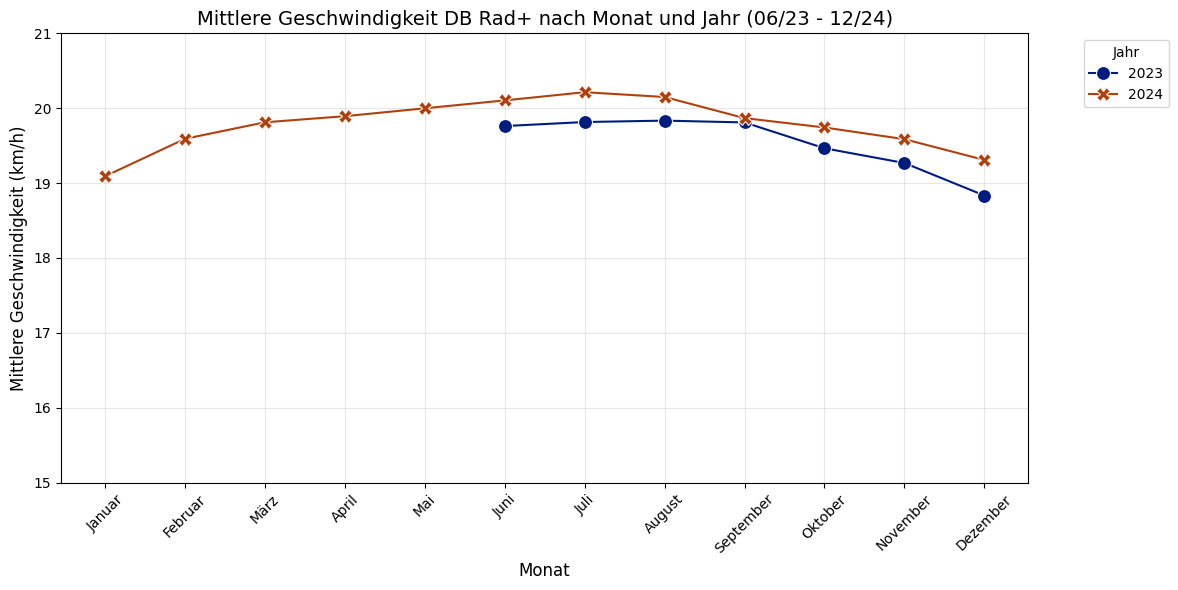

In [1]:
# Vergleichshistogramm Mittlere Geschwindigkeit, Monatsweise

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Daten laden
df = pd.read_csv('analysis_results/000_Zeitliche_Analysen/cycling_analysis_results.csv')

# Daten vorbereiten
monthly_data = df[df['period_type'] == 'monthly'].copy()
month_order = ['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 
               'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']

# German month names
monthly_data['month_name'] = pd.to_datetime(monthly_data['month'], format='%m').dt.strftime('%B')
monthly_data['month_name'] = monthly_data['month_name'].replace({
    'January': 'Januar',
    'February': 'Februar',
    'March': 'März',
    'April': 'April',
    'May': 'Mai',
    'June': 'Juni',
    'July': 'Juli',
    'August': 'August',
    'September': 'September',
    'October': 'Oktober',
    'November': 'November',
    'December': 'Dezember'
})

# Sortiere die Daten nach Monatsreihenfolge
monthly_data['month_name'] = pd.Categorical(monthly_data['month_name'], 
                                          categories=month_order,
                                          ordered=True)
monthly_data = monthly_data.sort_values('month_name')

# Plot erstellen
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x='month_name', y='mean', hue='year',
             style='year', markers=True, dashes=False, 
             markersize=10, palette='dark')

# Plot anpassen
plt.title('Mittlere Geschwindigkeit DB Rad+ nach Monat und Jahr (06/23 - 12/24)', fontsize=14)
plt.xlabel('Monat', fontsize=12)
plt.ylabel('Mittlere Geschwindigkeit (km/h)', fontsize=12)
plt.legend(title='Jahr', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.ylim(bottom=15, top=21)  # Adjust these values as needed

plt.show()